In [1]:
!pip3 install nltk textblob sentence-transformers keybert pyphen -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 87.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 124.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.0 MB/s eta 0:00:00


In [2]:
import nltk
import numpy as np
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, AutoModel

In [3]:
nltk.download('brown')
nltk.download('stopwords')
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [4]:
model_name = "microsoft/MiniLM-L12-H384-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [5]:
from keybert import KeyBERT

keybert_model = KeyBERT('distilbert-base-nli-mean-tokens')

In [6]:
import torch
import re

def calculate_flesch_reading_ease(text):
    # Remove punctuation from the text
    text = re.sub(r'[^\w\s]', '', text)

    # Split the text into sentences and words
    sentences = re.split(r'[.!?]', text)
    words = re.findall(r'\w+', text)

    # Calculate the average number of words per sentence
    average_words_per_sentence = len(words) / len(sentences)

    # Calculate the average number of syllables per word
    total_syllables = 0
    for word in words:
        total_syllables += count_syllables(word)
    average_syllables_per_word = total_syllables / len(words)

    # Calculate the Flesch Reading Ease score
    fre_score = 206.835 - (1.015 * average_words_per_sentence) - (84.6 * average_syllables_per_word)

    return fre_score

import pyphen

dic = pyphen.Pyphen(lang='en')

def count_syllables(word):
    hyphenated_word = dic.inserted(word)
    syllables = hyphenated_word.split('-')
    return len(syllables)

In [7]:
from transformers import pipeline

# Create a zero-shot classification pipeline using the BART-large-mnli model
zero_shot_pipeline = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=0)

In [8]:
import re
from collections import Counter
from nltk.corpus import stopwords

def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove newline characters
    text = re.sub(r'\n', ' ', text)

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text


def sentiment_alignment(text, summary):
    text = preprocess_text(text)
    summary = preprocess_text(summary)

    # Define the class names
    class_names = ["positive", "negative", "mixed"]

    # Get sentiment scores using the BART-large-mnli model
    text_sentiment = zero_shot_pipeline(text, class_names)
    text_output = text_sentiment['labels'][text_sentiment['scores'].index(max(text_sentiment['scores']))]

    summary_sentiment = zero_shot_pipeline(summary, class_names)
    summary_output = summary_sentiment['labels'][summary_sentiment['scores'].index(max(summary_sentiment['scores']))]

    if text_output == summary_output:
        return 1
    else:
        return 0


def detect_repetitive_phrases(input_string):
    stopwords_set = set(stopwords.words('english'))
    input_string = input_string.lower()
    words = re.findall(r'\b\w+\b', input_string)
    words = [word for word in words if word not in stopwords_set]
    phrases = [' '.join(t) for t in zip(words[:-2], words[1:-1], words[2:])]
    phrase_counts = Counter(phrases)
    repetitive_phrases = {phrase: count for phrase, count in phrase_counts.items() if count > 1}

    if repetitive_phrases:    # if dictionary is not empty
        return 0    # text contains repetitive phrases
    else:
        return 1    # no repetitive phrases found


def keyword_overlap(text_a, text_b):
    # Preprocess the text
    text_a = preprocess_text(text_a)
    text_b = preprocess_text(text_b)

    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform([text_a, text_b])
    overlap_score = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]
    return overlap_score


def sentence_similarity(sent_a, sent_b):
    # Tokenize the input sentences
    inputs = tokenizer([sent_a, sent_b], return_tensors="pt", padding=True, truncation=True, max_length=512)
    # Get the embeddings from the MiniLM model
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)
    # Calculate the similarity score
    similarity_score = torch.nn.functional.cosine_similarity(embeddings[0].unsqueeze(0), embeddings[1].unsqueeze(0)).item()
    return similarity_score


def keyword_overlap(text_a, text_b):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform([text_a, text_b])
    overlap_score = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]
    return overlap_score


def readability(text):
    preproc_text = preprocess_text(text)
    return calculate_flesch_reading_ease(preproc_text)


def count_noun_phrases(text):
    text = preprocess_text(text)
    blob = TextBlob(text)
    return blob.noun_phrases


def feature_highlighting(text, summary):
    text = preprocess_text(text)
    summary = preprocess_text(summary)

    # Extract keywords from the text and summary using KeyBERT
    text_keywords = set([kw[0] for kw in keybert_model.extract_keywords(text, keyphrase_ngram_range=(1, 2), stop_words='english')])
    summary_keywords = set([kw[0] for kw in keybert_model.extract_keywords(summary, keyphrase_ngram_range=(1, 2), stop_words='english')])

    # If both the text and summary have no keywords, return a score of 0
    if not text_keywords and not summary_keywords:
        return 0

    # Calculate the feature coverage score
    feature_coverage_score = len(text_keywords.intersection(summary_keywords)) / len(text_keywords)

    return feature_coverage_score


def extract_last_message(conversation):
    # Split the conversation string into individual messages
    messages = re.split(r'\nUser:', conversation)

    # Remove any leading or trailing whitespace from each message
    messages = [msg.strip() for msg in messages]

    # Identify the last message in the list of messages
    last_message = messages[-1]

    return last_message


def last_message_coverage(conversation, last_message, summary):
    return sentence_similarity(last_message, summary)


def context_inclusion(conversation, last_message, summary):
    conv_similarity = sentence_similarity(conversation, summary)
    last_msg_similarity = sentence_similarity(last_message, summary)
    return conv_similarity / last_msg_similarity


def pii_detection(summary, pii_list=[]):
    # Check for Twitter handles
    twitter_handle_pattern = r'@\w+'
    twitter_handles = re.findall(twitter_handle_pattern, summary)

    # Combine the PII list with the detected Twitter handles
    combined_pii_list = pii_list + twitter_handles

    # Check if any PII elements are present in the summary
    pii_present = any(pii in summary for pii in combined_pii_list)

    # Return 1 if no PII elements are present, 0 otherwise
    return 1 if not pii_present else 0


def product_name_presence(product_name, text, summary):
    if summary.lower() == "none":
        return 1
    in_text = product_name.lower() in text.lower()
    in_summary = product_name.lower() in summary.lower()
    return int(in_text == in_summary)

In [9]:
def evaluate_review_summary(product_name, text, summary):
    # Metrics for RecordTypeReview
    summary = preprocess_text(summary)

    coverage_score = keyword_overlap(text, summary)
    repitition_score = detect_repetitive_phrases(summary)
    text_sentences = len(preprocess_text(text).split('.'))
    summary_sentences = len(summary.split('.'))
    summary_to_text_ratio = summary_sentences / text_sentences
    conciseness_threshold = 0.7
    conciseness_score = 1 if summary_to_text_ratio <= conciseness_threshold else 0

    raw_clarity_score = max(0, calculate_flesch_reading_ease(summary)) if summary.lower() != "none" else 0  # Set a lower limit of 0 for clarity_score
    clarity_score = raw_clarity_score / 206.835
    sentiment_align_score = sentiment_alignment(text, summary)
    feature_highlight_score = feature_highlighting(text, summary)

    # Weights for RecordTypeReview
    weights = {
        "coverage": 0.1,
        "repitition": 0.1,
        "conciseness": 0.1,
        "clarity": 0.05,
        "sentiment_alignment": 0.2,
        "feature_highlighting": 0.2,
    }

    # Calculate the final evaluation score
    overall_score = (
        coverage_score * weights["coverage"]
        + repitition_score * weights["repitition"]
        + conciseness_score * weights["conciseness"]
        #+ clarity_score * weights["clarity"]
        + sentiment_align_score * weights["sentiment_alignment"]
        + feature_highlight_score * weights["feature_highlighting"]
    )
    return {
        "coverage_score": coverage_score,
        "repitition_score": repitition_score,
        #"clarity_score": clarity_score,
        "conciseness_score": conciseness_score,
        "sentiment_align_score": sentiment_align_score,
        "feature_highlight_score":feature_highlight_score,
        "overall_score": overall_score
    }

def evaluate_forum_conversation_summary(text, last_message, summary, pii_list=[]):
    # Metrics for RecordTypeForumConversation
    summary = preprocess_text(summary)

    coverage_score = keyword_overlap(text, summary)
    repitition_score = detect_repetitive_phrases(summary)
    text_sentences = len(preprocess_text(text).split('.'))
    summary_sentences = len(summary.split('.'))
    summary_to_text_ratio = summary_sentences / text_sentences
    conciseness_threshold = 0.7
    conciseness_score = 1 if summary_to_text_ratio <= conciseness_threshold else 0

    raw_clarity_score = max(0, calculate_flesch_reading_ease(summary)) if summary.lower() != "none" else 0
    clarity_score = raw_clarity_score / 206.835
    last_msg_coverage_score = last_message_coverage(text, last_message, summary)
    context_inclusion_score = context_inclusion(text, last_message, summary)
    pii_removal_score = pii_detection(summary, pii_list)

    # Weights for RecordTypeForumConversation
    weights = {
        "coverage": 0.1,
        "repitition": 0.1,
        "conciseness": 0.1,
        "clarity": 0.05,
        "last_message_coverage": 0.5,
        "context_inclusion": 0.2,
        "pii_removal": 1.0,
    }

    # Calculate the final evaluation score
    overall_score = (
        coverage_score * weights["coverage"]
        + repitition_score * weights["repitition"]
        + conciseness_score * weights["conciseness"]
        #+ clarity_score * weights["clarity"]
        + last_msg_coverage_score * weights["last_message_coverage"]
        + context_inclusion_score * weights["context_inclusion"]
        + pii_removal_score * weights["pii_removal"]
    )
    return {
        "coverage_score": coverage_score,
        #"clarity_score": clarity_score,
        "repitition_score":repitition_score,
        "conciseness_score": conciseness_score,
        "last_message_coverage_score": last_msg_coverage_score,
        "context_inclusion_score":context_inclusion_score,
        "pii_removal_score": pii_removal_score,
        "overall_score": overall_score
    }

def evaluate_survey_summary(product_name, text, summary):
    # Metrics for RecordTypeSurvey
    summary = preprocess_text(summary)

    coverage_score = keyword_overlap(text, summary)
    repitition_score = detect_repetitive_phrases(summary)
    text_sentences = len(preprocess_text(text).split('.'))
    summary_sentences = len(summary.split('.'))
    summary_to_text_ratio = summary_sentences / text_sentences
    conciseness_threshold = 0.7
    conciseness_score = 1 if summary_to_text_ratio <= conciseness_threshold else 0

    raw_clarity_score = max(0, calculate_flesch_reading_ease(summary)) if summary.lower() != "none" else 0
    clarity_score = raw_clarity_score / 206.835
    sentiment_align_score = sentiment_alignment(text, summary)
    feature_highlight_score = feature_highlighting(text, summary)

    # Weights for RecordTypeSurvey
    weights = {
        "coverage": 0.1,
        "repitition": 0.1,
        "conciseness": 0.1,
        "clarity": 0.05,
        "sentiment_alignment": 0.2,
        "feature_highlighting": 0.2,
    }

    # Calculate the final evaluation score
    overall_score = (
        coverage_score * weights["coverage"]
        + repitition_score * weights["repitition"]
        + conciseness_score * weights["conciseness"]
        #+ clarity_score * weights["clarity"]
        + sentiment_align_score * weights["sentiment_alignment"]
        + feature_highlight_score * weights["feature_highlighting"]
    )
    return {
        "coverage_score": coverage_score,
        "repitition_score": repitition_score,
        #"clarity_score": clarity_score,
        'conciseness_score':conciseness_score,
        "sentiment_align_score": sentiment_align_score,
        "feature_highlight_score":feature_highlight_score,
        "overall_score": overall_score
    }

In [10]:
def evaluate_summary(record_type, text, summary, product_name=None, pii_list=[]):
    if record_type == "Appstore/Playstore":
        return evaluate_review_summary(product_name, text, summary)
    elif record_type == "Twitter":
        last_message = extract_last_message(text)
        return evaluate_forum_conversation_summary(text, last_message, summary, pii_list)
    elif record_type == "G2":
        return evaluate_survey_summary(product_name, text, summary)
    else:
        raise ValueError(f"Unknown record type: {record_type}")

In [11]:
import pandas as pd


df = pd.read_csv("Enterpret Summary Generation Assignment - final_public_train.csv")
df.head(2)

,Customer,Type,Text,Summary
0,Notion,Appstore/Playstore,User: The app doesn't send sound or vibration ...,User finds the app useless without sound or vi...
1,Notion,Appstore/Playstore,"User: This app changed my life, I can only say...","User praises the app, stating it has changed t..."


In [12]:
print(df.query("Type=='Twitter'")['Text'].iloc[500])

User: .what is your best productivity tool as an SME/ startup entrepreneur? For me, it's Notion/ Airtable for now. #SageForSmallBiz #SageForStartups
User: @MorolongZA I love Notion but Airtable is one of my favourite tools ever. I used to spend so much time on ProductHunt. I think it’s time to discover some new stuff.
User: @rumbimak .my sister please, wena you're a shareholder in Notion. I need to play around with an AI tool that generates presentation designs or formats so I can just edit. I waste so much time worrying about designs. Canva doesn't help no more
User: @MorolongZA Firstly, @NotionHQ may as well give me shares at this point. Secondly, check out @MeetGamma. I haven’t used it yet but I’ve also been looking for the same solution.


In [13]:
print(df.query("Type=='G2'")['Text'].iloc[230])

User: Helping with our discovery process for opportunity solutions trees, for roadmap and timelines, for anything really
User: I love that there's "infinite space" , if you prep a presentation on ppt for example, you're limited to slides but with Miro the sky is the limit
User: We have a business account and sometimes colleagues from other departments are part of a different account and we can't give them editing rights to the boards


In [14]:
df.columns = ['customer', 'type', 'text', 'summary']

In [15]:
df.head(2)

,customer,type,text,summary
0,Notion,Appstore/Playstore,User: The app doesn't send sound or vibration ...,User finds the app useless without sound or vi...
1,Notion,Appstore/Playstore,"User: This app changed my life, I can only say...","User praises the app, stating it has changed t..."


In [16]:
print(df.shape)

df = df.dropna()
print(f"Data after dropping null values: {df.shape}")

df = df.drop_duplicates(keep='first')

print(f"Data after dropping duplicate rows: {df.shape}")

(5009, 4)
Data after dropping null values: (4857, 4)
Data after dropping duplicate rows: (4857, 4)


In [17]:
def is_empty_string(value):
    return value.strip() == ""

empty_string_check = df[['text', 'summary']].applymap(is_empty_string)
df = df[~empty_string_check.any(axis=1)]
print(f"Data after dropping rows w/ empty strings: {df.shape}")

Data after dropping rows w/ empty strings: (4838, 4)


In [18]:
appstore_df = df[df['type'] == 'Appstore/Playstore']
twitter_df = df[df['type'] == 'Twitter']
g2_df = df[df['type'] == 'G2']

In [19]:
print(g2_df.shape)
print(twitter_df.shape)
print(appstore_df.shape)

(398, 4)
(2971, 4)
(1469, 4)


In [20]:
import pandas as pd
from tqdm import tqdm

# Register the progress_apply function with pandas
tqdm.pandas()

g2_df_features = g2_df.progress_apply(
    lambda row: evaluate_summary(
        row['type'],
        row['text'],
        row['summary'],
        product_name=row.get('customer'),
    ),
    axis=1
)

  2%|▏         | 6/398 [00:07<08:04,  1.24s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  2%|▏         | 7/398 [00:08<07:38,  1.17s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  2%|▏         | 8/398 [00:09<06:32,  1.01s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  2%|▏         | 9/398 [00:10<05:33,  1.17it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximi

In [25]:
g2_df.reset_index(drop=True, inplace=True)
g2_df['row_number'] = g2_df.index

g2_df_features_df = pd.DataFrame(g2_df_features.tolist())
g2_df_features_df.reset_index(drop=True, inplace=True)
g2_df_features_df['row_number'] = g2_df_features_df.index

merged_g2_df = pd.merge(g2_df, g2_df_features_df, on='row_number', how='inner')

merged_g2_df.drop(columns=['row_number'], inplace=True)

<ipython-input-25-e023b8b86d2a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g2_df['row_number'] = g2_df.index


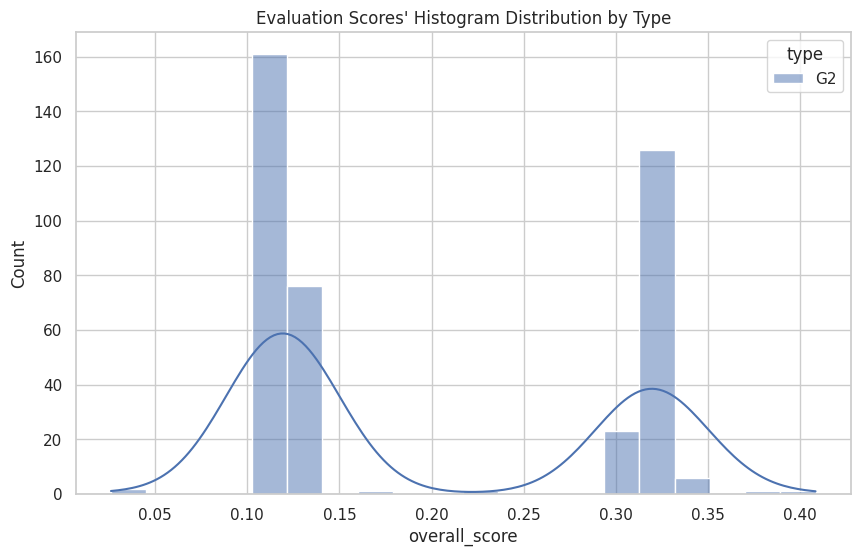

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(data=merged_g2_df, x="overall_score", hue="type", kde=True, bins=20)
plt.title("Evaluation Scores' Histogram Distribution by Type")
plt.show()


In [27]:
merged_g2_df.sort_values(by="overall_score", ascending=True).head()

,customer,type,text,summary,coverage_score,repitition_score,conciseness_score,sentiment_align_score,feature_highlight_score,overall_score
173,figma,G2,"User: Sharing ideas, knowlede and developing s...",User is benefiting from Miro's range of templa...,0.260800,0,0,0,0.0,0.026080
313,figma,G2,"User: Miro is easy to use, and has key feature...",The user finds the tool extremely valuable for...,0.334428,0,0,0,0.0,0.033443
295,figma,G2,User: easier to create real time diagrams and ...,Users appreciate Miro as a digital whiteboardi...,0.029254,1,0,0,0.0,0.102925
354,figma,G2,User: It helps in creating new designs for the...,User finds Figma useful for collaboration and ...,0.053632,1,0,0,0.0,0.105363
291,figma,G2,User: Ability to share visions/ ideas/ plans w...,Users appreciate Miro's quick and easy-to-use ...,0.062527,1,0,0,0.0,0.106253


In [28]:
merged_g2_df.sort_values(by="overall_score", ascending=True).tail()

,customer,type,text,summary,coverage_score,repitition_score,conciseness_score,sentiment_align_score,feature_highlight_score,overall_score
325,figma,G2,User: There is easy collaboration between the ...,The product is helping the User with their dis...,0.355685,1,0,1,0.0,0.335568
326,figma,G2,User: Miro is a key success tool for making yo...,The User is benefiting from the product by hav...,0.368923,1,0,1,0.0,0.336892
190,figma,G2,User: Our Design team needed a tool that is ea...,The user appreciates the flexibility and timer...,0.455076,1,0,1,0.0,0.345508
327,figma,G2,User: The overall problem that FigJam is solvi...,The user finds MIRO to be a great collaborati...,0.337008,1,0,1,0.2,0.373701
268,figma,G2,User: Miro allows us to work on projects concu...,Users appreciate Miro's collaborative capabili...,0.282682,1,0,1,0.4,0.408268


In [29]:
# Apply the evaluate_summary function with a progress bar
appstore_df_features = appstore_df.progress_apply(
    lambda row: evaluate_summary(
        row['type'],
        row['text'],
        row['summary'],
        product_name=row.get('customer'),
    ),
    axis=1
)

  0%|          | 0/1469 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  0%|          | 2/1469 [00:00<02:54,  8.38it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  0%|          | 3/1469 [00:00<04:13,  5.78it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  0%|          | 4/1469 [00:00<05:12,  4.68it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize e

In [32]:
appstore_df.reset_index(drop=True, inplace=True)
appstore_df['row_number'] = appstore_df.index

appstore_df_features_df = pd.DataFrame(appstore_df_features.tolist())
appstore_df_features_df.reset_index(drop=True, inplace=True)
appstore_df_features_df['row_number'] = appstore_df_features_df.index

merged_appstore_df = pd.merge(appstore_df, appstore_df_features_df, on='row_number', how='inner')

merged_appstore_df.drop(columns=['row_number'], inplace=True)

<ipython-input-32-a1fc52ccb353>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  appstore_df['row_number'] = appstore_df.index


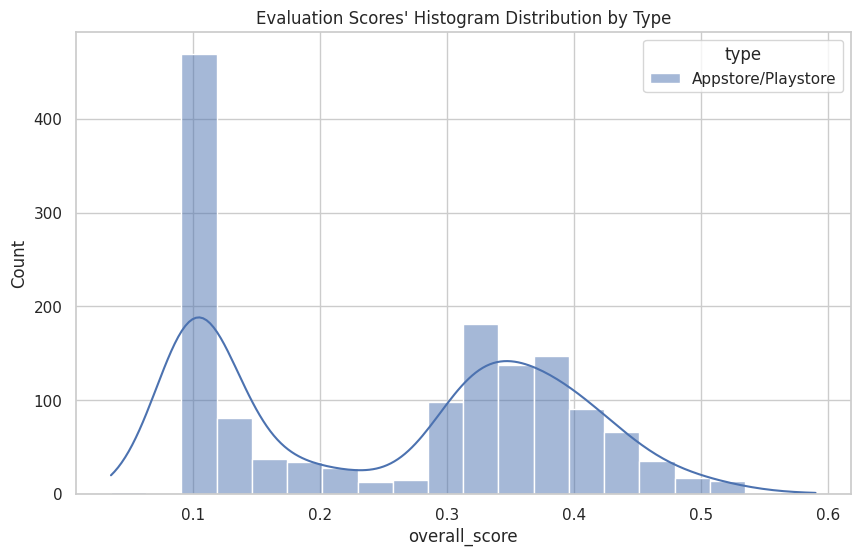

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(data=merged_appstore_df, x="overall_score", hue="type", kde=True, bins=20)
plt.title("Evaluation Scores' Histogram Distribution by Type")
plt.show()


In [35]:
merged_g2_df.sort_values(by="overall_score", ascending=True).head()

,customer,type,text,summary,coverage_score,repitition_score,conciseness_score,sentiment_align_score,feature_highlight_score,overall_score
173,figma,G2,"User: Sharing ideas, knowlede and developing s...",User is benefiting from Miro's range of templa...,0.260800,0,0,0,0.0,0.026080
313,figma,G2,"User: Miro is easy to use, and has key feature...",The user finds the tool extremely valuable for...,0.334428,0,0,0,0.0,0.033443
295,figma,G2,User: easier to create real time diagrams and ...,Users appreciate Miro as a digital whiteboardi...,0.029254,1,0,0,0.0,0.102925
354,figma,G2,User: It helps in creating new designs for the...,User finds Figma useful for collaboration and ...,0.053632,1,0,0,0.0,0.105363
291,figma,G2,User: Ability to share visions/ ideas/ plans w...,Users appreciate Miro's quick and easy-to-use ...,0.062527,1,0,0,0.0,0.106253


In [36]:
merged_g2_df.sort_values(by="overall_score", ascending=True).tail()

,customer,type,text,summary,coverage_score,repitition_score,conciseness_score,sentiment_align_score,feature_highlight_score,overall_score
325,figma,G2,User: There is easy collaboration between the ...,The product is helping the User with their dis...,0.355685,1,0,1,0.0,0.335568
326,figma,G2,User: Miro is a key success tool for making yo...,The User is benefiting from the product by hav...,0.368923,1,0,1,0.0,0.336892
190,figma,G2,User: Our Design team needed a tool that is ea...,The user appreciates the flexibility and timer...,0.455076,1,0,1,0.0,0.345508
327,figma,G2,User: The overall problem that FigJam is solvi...,The user finds MIRO to be a great collaborati...,0.337008,1,0,1,0.2,0.373701
268,figma,G2,User: Miro allows us to work on projects concu...,Users appreciate Miro's collaborative capabili...,0.282682,1,0,1,0.4,0.408268


In [37]:
twitter_df_features = twitter_df.progress_apply(
    lambda row: evaluate_summary(
        row['type'],
        row['text'],
        row['summary'],
        product_name=row.get('customer'),
    ),
    axis=1
)

100%|██████████| 2971/2971 [15:46<00:00,  3.14it/s]


In [38]:
twitter_df.reset_index(drop=True, inplace=True)
twitter_df['row_number'] = twitter_df.index

twitter_df_features_df = pd.DataFrame(twitter_df_features.tolist())
twitter_df_features_df.reset_index(drop=True, inplace=True)
twitter_df_features_df['row_number'] = twitter_df_features_df.index

merged_twitter_df = pd.merge(twitter_df, twitter_df_features_df, on='row_number', how='inner')

merged_twitter_df.drop(columns=['row_number'], inplace=True)

<ipython-input-38-1964ad13ab13>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twitter_df['row_number'] = twitter_df.index


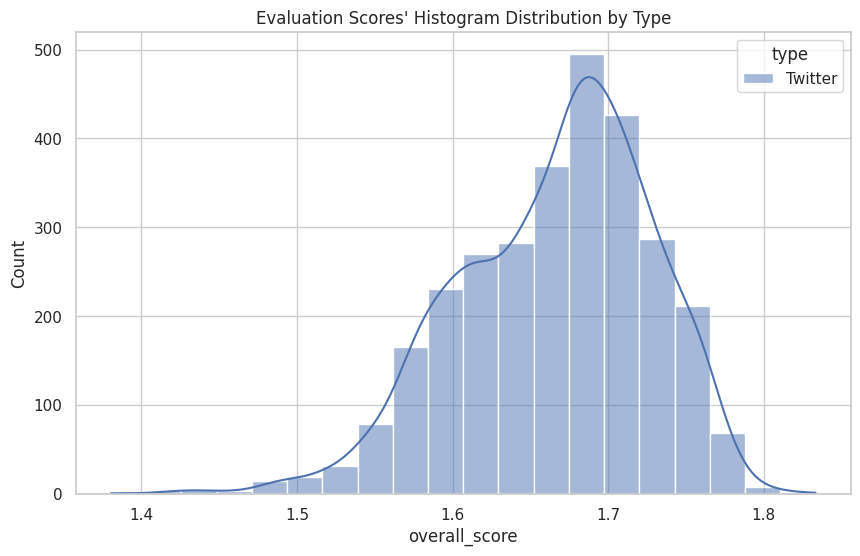

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(data=merged_twitter_df, x="overall_score", hue="type", kde=True, bins=20)
plt.title("Evaluation Scores' Histogram Distribution by Type")
plt.show()

In [40]:
merged_twitter_df.sort_values(by="overall_score", ascending=True).head()

,customer,type,text,summary,coverage_score,repitition_score,conciseness_score,last_message_coverage_score,context_inclusion_score,pii_removal_score,overall_score
1256,Notion,Twitter,User: Pretty! 💙\n@browsercompany <STRICT_LINK>,User: I'm not sure if I'm the only one who's h...,0.004616,0,0,0.359986,1.000000,1,1.380455
1233,Notion,Twitter,User: @arcinternet @joshm I’m stuck in a loop ...,User is experiencing issues with their browser...,0.053403,0,0,0.409011,1.000000,1,1.409846
1699,Notion,Twitter,"User: block module from my @AREdotNA restyle, ...",User is using the browserCO app and is experie...,0.044448,0,0,0.355421,1.204454,1,1.423046
1039,Notion,Twitter,"User: ‘Twas a pleasure to make the move,\nTo a...",User is excited about the new features in the ...,0.208307,0,0,0.408299,1.000000,1,1.424980
1695,Notion,Twitter,User: Does anyone else using @browsercompany's...,User is using the browserCO app and is experie...,0.030847,0,0,0.367524,1.200195,1,1.426886


In [47]:
merged_twitter_df.sort_values(by="overall_score", ascending=True).tail()

,customer,type,text,summary,coverage_score,repitition_score,conciseness_score,last_message_coverage_score,context_inclusion_score,pii_removal_score,overall_score
153,Notion,Twitter,User: How to add Sign In with Notion integrati...,User is seeking advice on how to add a Sign In...,0.641122,1,0,0.873788,1.0,1,1.801006
2892,figma,Twitter,User: I like my layers to be sorted from top t...,Users are experiencing an issue with Figma's ...,0.305541,1,0,0.951197,1.0,1,1.806153
528,Notion,Twitter,User: NotionAI from @NotionHQ simplifies many ...,User is excited about the new Notion AI featu...,0.391141,1,0,0.942762,1.0,1,1.810495
1537,Notion,Twitter,User: Absolutely loving the new features @arci...,User is excited about the new features in the ...,0.569797,1,0,0.921757,1.0,1,1.817858
549,Notion,Twitter,User: Seems there is no way to cancel a @Notio...,User is frustrated with the lack of a way to c...,0.522895,1,0,0.961898,1.0,1,1.833238


In [60]:
merged_g2_df.query('overall_score < 0.30').sort_values(by="overall_score", ascending=True).shape

(241, 10)

In [57]:
merged_appstore_df.query('overall_score < 0.30').sort_values(by="overall_score", ascending=True).shape

(682, 10)

In [58]:
merged_twitter_df.query('overall_score < 1.6').sort_values(by="overall_score", ascending=True).shape

(485, 11)

In [61]:
sampled_g2_df = merged_g2_df.query('overall_score > 0.30')
sampled_appstore_df = merged_appstore_df.query('overall_score > 0.30')
sampled_twitter_df = merged_twitter_df.query('overall_score > 1.6')

In [64]:
sampled_final_df = pd.concat([sampled_g2_df, sampled_appstore_df, sampled_twitter_df], axis=0)

In [68]:
final_df = sampled_final_df[['customer', 'type', 'text', 'summary']]
final_df

,customer,type,text,summary
0,figma,G2,User: It makes it so much easier to design for...,Users appreciate Figma for its prototyping an...
2,figma,G2,User: I was using Miro for brainstorming and m...,Users appreciate Miro's large workspace and wh...
4,figma,G2,User: It's the go-to design tool in our team. ...,User appreciates Figma's seamless screen creat...
5,figma,G2,"User: Practically everything, my daily life as...",Users find FigJam to be an excellent tool for ...
10,figma,G2,"User: Right now, we're just using it as a retr...",Users appreciate Miro for its seamless team co...
...,...,...,...,...
2966,figma,Twitter,User: Missing “fix position when scrolling” op...,User needs to edit font colors and logo in the...
2967,figma,Twitter,User: When I search I feel that it’s intuitive...,User faces issue with importing an SVG file in...
2968,figma,Twitter,User: When I search I feel that it’s intuitive...,User wants to edit the font colors and logo in...
2969,figma,Twitter,User: Trying to apply several transformations ...,A user was looking for a way to convert table...


In [70]:
sampled_final_df.to_csv('sampled_final_df_analysis.csv', index=False)
final_df.to_csv('final_df_analysis.csv', index=False)